# Recriação do Indicador de Ciclo de Crédito (CCI) da S&P Rating.

### Introdução:

Desde a crise financeira global, bancos centrais mantiveram políticas monetárias acomodatícias para estabilizar a economia e mercados financeiros. Recentemente, essas políticas foram ainda mais facilitadas durante a pandemia de COVID-19. Observando a necessidade de uma ferramenta que consolidasse informações sobre endividamento, preços de ativos e condições de financiamento, a S&P desenvolveu o Indicador de Ciclo de Crédito (CCI), que pretende ser um indicador antecipado de estresse de crédito. O CCI combina cinco componentes: alavancagem da dívida corporativa e das famílias, preços de ações e de imóveis, e o Indicador de Estresse de Financiamento (FSI) da S&P.

### Metodologia:

O desenvolvimento do CCI é fundamentado em pesquisas acadêmicas que demonstram que o crescimento do crédito em relação ao PIB e a inflação dos preços dos ativos podem aumentar a probabilidade de crises financeiras. O CCI considera os seguintes componentes, conforme tabela abaixo:

| Componente                         | Fonte de Dados                             |
|------------------------------------|--------------------------------------------|
| Crédito ao setor familiar (% do PIB)| Banco de Compensações Internacionais (BIS) |
| Crédito ao setor corporativo não financeiro (% do PIB) | BIS          |
| Índices de preços de imóveis reais | BIS                                        |
| Índices de preços de ações, deflacionados pelo CPI | Bloomberg, Fundo Monetário Internacional (FMI) |
| Indicador de Estresse de Financiamento (FSI) | S&P Global Ratings |

### Tratamentos e Transformações de Dados:

Os dados brutos são organizados por economia e depois agregados regionalmente. Os componentes do CCI passam por várias transformações antes de serem filtrados pelo método de Christiano-Fitzgerald (2003). Este filtro remove tendências de longo prazo, ruídos e sazonalidades de alta frequência, e ciclos com periodicidade maior que 10 anos. Após a filtragem, os dados são normalizados para garantir comparabilidade.

| Componente                         | Transformação Antes do Filtro               | Unidades Após o Filtro              |
|------------------------------------|--------------------------------------------|------------------------------------|
| Crédito/PIB (Famílias e Corporativas) | Nenhuma                                   | Desvio dos ciclos de longo prazo (% do PIB) |
| Preços de Ativos (Ações e Imóveis) | Logaritmo Natural                          | Desvio dos ciclos de longo prazo (%) |
| FSI                                | Negativo do Logaritmo Natural               | Leituras positivas indicam condições mais frouxas, medidas em desvios padrão do ciclo de longo prazo |

### Construção e Padronização Final:

Cada CCI por país é calculado como a soma ponderada igualmente dos cinco componentes. As subindicadores de famílias e corporativos são calculados como a média dos respectivos componentes filtrados. Os CCIs por país e suas subindicadores são, então, escalonados para garantir média zero e desvio padrão de 1, resultando em unidades de desvios padrão em relação à média histórica.

##### Leitura das Bases:

In [24]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from colorama import init, Fore, Style
from statsmodels.tsa.filters.cf_filter import cffilter

# Iniciando o colorama:
init()

In [2]:
def process_csv(file_path, column_name, date_column='date', delimiter=';'):
    df = pd.read_csv(file_path, sep=delimiter)
    df[column_name] = df[column_name].str.replace(',', '.').astype(float)
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    return df

# Caminhos:
household_sector_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão USA\Dados\Total Credit to Households.csv'
private_sector_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão USA\Dados\Total Credit to Private.csv'
real_residential_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão USA\Dados\Real Residential Property Prices.csv'
real_sp500_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão USA\Dados\Real S&P 500.csv'
fsi_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão USA\Dados\fsi st louis fed.xlsx'

# Processando os CSVs:
household_sector = process_csv(household_sector_path, 'credit_households')
private_sector = process_csv(private_sector_path, 'credit_private')

real_residential = process_csv(real_residential_path, 'real_residential')
real_residential = real_residential.iloc[:-1]

real_sp500 = process_csv(real_sp500_path, 'real_sp500')

# Caso especial para o FSI:
fsi = pd.read_excel(fsi_path)
# fsi.drop(columns=['OFR FSI', 'Credit', 'Equity valuation', 'Safe assets',
#                 'Funding', 'Volatility', 'Other advanced economies',
#                 'Emerging markets'], inplace=True)

fsi['date'] = pd.to_datetime(fsi['date'])
fsi.set_index('date', inplace=True)

##### Manipulação das Bases:

Transformando as séries `real_sp500` e `fsi` de mensal/diario para trimestral:

`fsi`

In [3]:
fsi_quarterly = fsi.resample('QE').last()
fsi_quarterly.index = fsi_quarterly.index + pd.offsets.QuarterBegin(startingMonth=1)
fsi_quarterly.head()

,fsi
date,
1994-01-01,-0.3099
1994-04-01,-0.2584
1994-07-01,-0.1222
1994-10-01,-0.2329
1995-01-01,-0.0519


`real_sp500`

In [4]:
real_sp500_quarterly = real_sp500.resample('QE').last()
real_sp500_quarterly.index = real_sp500_quarterly.index + pd.offsets.QuarterBegin(startingMonth=1)
real_sp500_quarterly.head()

,real_sp500
date,
1948-01-01,15.03
1948-04-01,14.30
1948-07-01,16.82
1948-10-01,15.76
1949-01-01,15.19


##### Tratamentos e Transformações de Dados: Statistical Filter

O Filtro Band Pass de Christiano-Fitzgerald é projetado para isolar componentes específicos de frequência em uma série temporal, permitindo a análise de flutuações dentro de faixas de frequência designadas. Este filtro é particularmente útil na análise macroeconômica, onde entender as dinâmicas dos ciclos econômicos e tendências de longo prazo é essencial.

**Visão Geral do Filtro Passa-Faixa**

O filtro Band Pass, em sua forma ideal, isola o componente de uma série temporal que se encontra dentro de uma faixa específica de frequências. No entanto, aplicar o filtro ideal requer uma quantidade infinita de dados, o que é impraticável. Portanto, Christiano e Fitzgerald desenvolveram uma aproximação ótima para conjuntos de dados finitos.

**Componentes do Filtro**

1. **Filtro Band Pass Ideal**:
    - O filtro Band Pass ideal, \( B(L) \), é definido matematicamente para isolar frequências entre \( a \) e \( b \) (onde \( 0 < a \leq b \leq \pi \)).
    - O filtro é representado como:
      $$
      y_t = B(L)x_t = \sum_{j=-\infty}^{\infty} B_j L^j x_t
      $$
    - Os coeficientes \( B_j \) são dados por:
      $$
      B_j = \frac{\sin(jb) - \sin(ja)}{\pi j}, \quad j \neq 0
      $$
      $$
      B_0 = \frac{b - a}{\pi}
      $$
    - Esta estrutura garante que o filtro retenha os componentes de frequência entre \( a \) e \( b \), eliminando outros.

2. **Dados Finitos e Aproximação**:
    - Dada a impraticabilidade de dados infinitos, Christiano e Fitzgerald derivam uma aproximação usando dados finitos.
    - A aproximação envolve projetar o filtro ideal nos dados disponíveis, otimizando a projeção para minimizar o erro quadrático médio:
      $$
      E \left[(y_t - \hat{y}_t)^2 \mid x\right]
      $$
    - Os pesos do filtro \( \hat{B}_j \) são calculados para fazer \( \hat{y}_t \) o mais próximo possível do ideal \( y_t \).

**Implementação do Filtro**

1. **Assunção de Caminhada Aleatória**:
    - Christiano e Fitzgerald propõem uma abordagem simplificada assumindo que os dados seguem uma caminhada aleatória:
      $$
      x_t = x_{t-1} + \epsilon_t
      $$
    - Essa assunção permite um cálculo direto dos pesos do filtro.

2. **Pesos Ótimos**:
    - Para um determinado período \( t \), o filtro é calculado como:
      $$
      \hat{y}_t = B_0 x_t + B_1 x_{t+1} + \dots + B_{T-1-t} x_{T-1} + \tilde{B}_{T-t} x_T + B_1 x_{t-1} + \dots + B_{t-2} x_2 + \tilde{B}_{t-1} x_1
      $$
    - Onde:
      $$
      \tilde{B}_{T-t} = -\frac{1}{2}B_0 - \sum_{j=1}^{T-t-1} B_j
      $$
      $$
      \tilde{B}_{t-1} = -\frac{1}{2}B_0 - \sum_{j=1}^{t-2} B_j
      $$

**Aplicação Empírica**

1. **Curva de Phillips e Relação Dinheiro-Inflação**:
    - O filtro é aplicado para analisar mudanças na curva de Phillips e na relação dinheiro-inflação antes e depois da década de 1960.
    - Os resultados indicam pouca mudança na curva de Phillips, mas mudanças substanciais na relação dinheiro-inflação.

2. **Estimativas em Tempo Real**:
    - O filtro fornece estimativas em tempo real úteis para a política de estabilização macroeconômica, como determinar se as mudanças na produção fazem parte de uma tendência ou são mais transitórias.

**Vantagens e Limitações**

1. **Vantagens**:
    - Não requer comprometimento com um modelo estatístico específico dos dados.
    - Aproximações ótimas são derivadas usando as propriedades espectrais dos dados.
    - Eficaz para séries temporais macroeconômicas padrão.

2. **Limitações**:
    - A otimalidade é alcançada para representações específicas de séries temporais; pode não funcionar bem para todos os tipos de dados.
    - Assume ausência de tendência na caminhada aleatória; requer ajuste de tendência para dados brutos com tendência.

Dado a explicação acima, iremos aplicar o filtro de `Christiano-Fitzgerald` com periodicidade entre `6 e 40 trimestres`, e assim obter o componente de `Ciclo de 1,5 a 10 anos` para cada série:

In [5]:
def get_cycles(series_dict, low=6, high=40):
    """
    Obtém os componentes de ciclo para uma lista de séries temporais.

    Parameters:
    series_dict (dict): Dicionário onde a chave é o nome da série e o valor é a série temporal (pandas Series).
    low (int): Período baixo do filtro para obter os ciclos.
    high (int): Período alto do filtro para obter os ciclos.

    Returns:
    pd.DataFrame: DataFrame contendo os componentes de ciclo de cada série.
    """

    cycles = {}
    for name, series in series_dict.items():
        cycle, trend = cffilter(series, low=low, high=high)
        cycles[name] = cycle
    return pd.DataFrame(cycles)

# Aqui já será incluida as transformações necessárias para cada série:
series_dict = {
    # Não há nenhuma Transformação:
    'household': household_sector['credit_households'],
    'private': private_sector['credit_private'],
    
    # Transformação 'Logaritmo Natural':
    'residential': np.log(real_residential['real_residential']),
    'equity': np.log(real_sp500_quarterly),
    
    # Transformação 'Negativo do logaritmo natural':
    # Aqui foi preciso alterar a escala da série, pois ela usa números índices, e 
    # usar tanto o ln quanto o -ln ocorrera um erro devido a valores negativos.
    # A escala utilizada foi a seguinte: (x*1)+10.
    'fsi': -np.log((fsi_quarterly - fsi_quarterly.mean() / fsi_quarterly.std())*1+10)
}

cycles = get_cycles(series_dict)
print(cycles.tail(10))

            household   private  residential    equity       fsi
date                                                            
2022-07-01   0.264818  0.078744     0.040085 -0.024104 -0.015917
2022-10-01  -0.130288 -0.834263     0.024948 -0.093220 -0.024316
2023-01-01  -0.634170 -2.045970     0.014206 -0.125833 -0.018515
2023-04-01  -1.163715 -3.248388     0.010644 -0.118506 -0.004851
2023-07-01  -1.557826 -4.105199     0.012664 -0.083655  0.010266
2023-10-01  -1.684159 -4.422648     0.016023 -0.039706  0.021788
2024-01-01        NaN       NaN          NaN -0.000639  0.027051
2024-04-01        NaN       NaN          NaN  0.028346  0.026311
2024-07-01        NaN       NaN          NaN  0.047967  0.022074
2024-10-01        NaN       NaN          NaN  0.059449  0.017185


In [602]:
cycles.to_excel('cycles2.xlsx')

**Analisando os Componentes do Filtro de Christiano-Fitzgerald para qualquer série:**

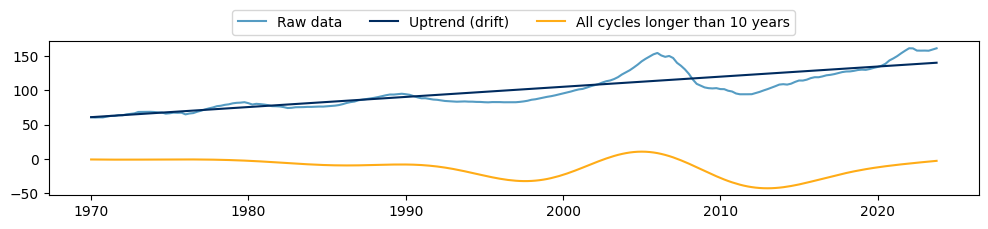

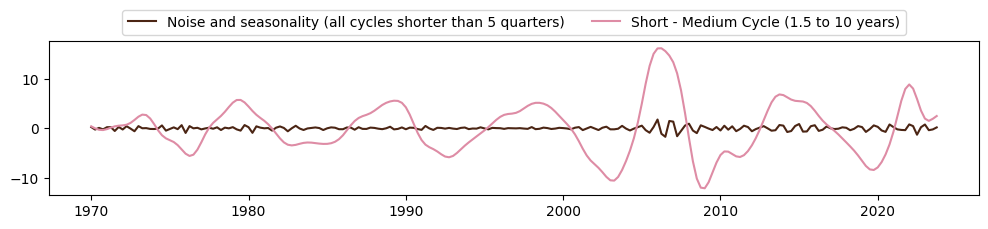

In [400]:
def analyze_series(series):
    # Converter o índice datetime para numérico (dias desde o início):
    numeric_index = (series.index - series.index[0]).days

    # Calculando a linha de tendência linear (drift):
    coefficients = np.polyfit(numeric_index, series, 1)
    linear_trend = np.polyval(coefficients, numeric_index)

    # Ajustar a linha de tendência para começar no valor inicial dos dados:
    linear_trend = linear_trend - (linear_trend[0] - series.iloc[0])

    # Filtro para ciclos mais longos que 10 anos - especificamos um limite inferior alto para capturar apenas os ciclos muito longos:
    cf_filter_long = cffilter(series, low=40, high=np.inf)

    # Filtro para ruído e sazonalidade (ciclos menores que 5 trimestres) - capturamos apenas os componentes de alta frequência:
    cf_filter_noise = cffilter(series, low=2, high=5)

    # Entrada CCI (ciclos entre 1.5 e 10 anos) - capturamos os ciclos de curto a médio prazo:
    cf_filter_cci = cffilter(series, low=6, high=40)

    # Plotar todos os componentes:
    plt.figure(figsize=(12, 2))
    plt.plot(series, label='Raw data', color='#559cc3')
    plt.plot(series.index, linear_trend, label='Uptrend (drift)', color='#002b5f')
    plt.plot(cf_filter_long[0], label='All cycles longer than 10 years', color='#ffac17')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
    plt.show()

    plt.figure(figsize=(12, 2))
    plt.plot(cf_filter_noise[0], label='Noise and seasonality (all cycles shorter than 5 quarters)', color='#4b2514')
    plt.plot(cf_filter_cci[0], label='Short - Medium Cycle (1.5 to 10 years)', color='#de8ca5')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
    plt.show()

analyze_series(real_residential['real_residential'])

##### Tratamentos e Transformações de Dados: Further Specifics

Depois de transformar e filtrar cada entrada, as séries temporais resultantes são todas dimensionadas para uma média 0 e 
desvio padrão de 1, para garantir que todos tenham unidades comparáveis.

In [6]:
zscore = cycles.apply(lambda x:
                    (x-x.mean())/x.std(), axis=0)

zscore.head(10)

,household,private,residential,equity,fsi
date,,,,,
1947-10-01,-0.700945,-0.520153,NaN,NaN,NaN
1948-01-01,-0.689629,-0.524998,NaN,0.349380,NaN
1948-04-01,-0.660569,-0.563561,NaN,0.514875,NaN
1948-07-01,-0.605318,-0.617764,NaN,0.457769,NaN
1948-10-01,-0.491877,-0.621951,NaN,0.127302,NaN
1949-01-01,-0.268463,-0.485825,NaN,-0.353090,NaN
1949-04-01,0.116972,-0.141955,NaN,-0.766629,NaN
1949-07-01,0.681978,0.405887,NaN,-0.940963,NaN
1949-10-01,1.372252,1.060826,NaN,-0.837486,NaN


##### Weighted Sum And Final Standardization

Em seguida, pegamos todos os cinco dados e calculamos o ICC com os seus valores igualmente iguais utilizando `Soma Ponderada`. Este cálculo só é feito a partir do período em que todas as cinco entradas 
estão disponíveis - ou seja, o histórico máximo disponível para qualquer CCI começa no primeiro trimestre de 1995, quando o FSI começa. Os subindicadores para famílias (Household) e empresas (Private) também são calculados como a média de entradas relevantes de crédito filtrado e preços de ativos.

A soma ponderada é calculada usando a seguinte fórmula:

\begin{equation}
\text{CCI}_t = \sum_{i=1}^{n} w_i \times C_{i,t}
\end{equation}

Onde:
* $\text{CCI}_t$ é o valor do Credit Cycle Indicator no tempo $t$.
* $C_{i,t}$ é o ciclo $i$ no tempo $t$.
* $w_i$ é o peso atribuído ao ciclo $i$.
* $n$ é o número total de ciclos (séries).

Os pesos são geralmente escolhidos com base em análise empírica ou julgamento especializado para refletir a importância relativa de cada componente.

Após calcular a soma ponderada, ela é padronizada para ter média zero e desvio padrão um. A padronização é realizada usando a fórmula:

\begin{equation}
\text{CCI}_{\text{final}} = \frac{\text{CCI} - \mu}{\sigma}
\end{equation}

Onde:
* $\mu$ é a média da soma ponderada.
* $\sigma$ é o desvio padrão da soma ponderada.

O ICC do país e os subindicadores também são escalonados, para garantir que todos tenham uma média 
0 e desvio padrão 1. Como tal, todos os CCIs estão em unidades de desvio padrão distantes de 
média histórica

In [7]:
def weighted_sum_and_standardize(cycles_dict, weights, start_period='1995Q1'):
    """
    Calcula a soma ponderada das séries de ciclos e padroniza o resultado final,
    começando do período em que todos os dados estão disponíveis.

    Parameters:
    cycles_dict (dict): Dicionário onde a chave é o nome da série e o valor é a série temporal filtrada (ciclo).
    weights (dict): Dicionário onde a chave é o nome da série e o valor é o peso atribuído a ela.
    start_period (str): Período inicial para cálculo, formato 'YYYYQX'.

    Returns:
    pd.Series: Série padronizada representando o Credit Cycle Indicator (CCI).
    """
    # Truncar a série para começar no período especificado:
    truncated_cycles = {name: cycles.loc[start_period:] for name, cycles in cycles_dict.items()}

    # Calcula a soma ponderada das séries de ciclos:
    weighted_sum = sum(weights[name] * cycles for name, cycles in truncated_cycles.items())

    # Padroniza a soma ponderada:
    cci = (weighted_sum - weighted_sum.mean()) / weighted_sum.std()
    return cci

def calculate_sub_indicators(cycles_dict, start_period='1995Q1'):
    """
    Calcula os sub-indicadores para domicílios e empresas.

    Parameters:
    cycles_dict (dict): Dicionário onde a chave é o nome da série e o valor é a série temporal filtrada (ciclo).
    start_period (str): Período inicial para cálculo, formato 'YYYYQX'.

    Returns:
    dict: Dicionário contendo os sub-indicadores padronizados.
    """
    # Trunca as séries para começar do período especificado
    truncated_cycles = {name: cycles.loc[start_period:] for name, cycles in cycles_dict.items()}

    # Calcula o sub-indicador para domicílios (média dos componentes relevantes)
    household_sub_indicator = (truncated_cycles['household'] + truncated_cycles['residential']) / 2

    # Calcula o sub-indicador para empresas (média dos componentes relevantes)
    corporate_sub_indicator = (truncated_cycles['private'] + truncated_cycles['equity']) / 2

    # FSI já está truncado e não precisa de cálculos adicionais
    fsi_sub_indicator = truncated_cycles['fsi']

    # Padroniza os sub-indicadores
    household_sub_indicator = (household_sub_indicator - household_sub_indicator.mean()) / household_sub_indicator.std()
    corporate_sub_indicator = (corporate_sub_indicator - corporate_sub_indicator.mean()) / corporate_sub_indicator.std()
    fsi_sub_indicator = (fsi_sub_indicator - fsi_sub_indicator.mean()) / fsi_sub_indicator.std()

    return {
        'household_sub_indicator': household_sub_indicator,
        'corporate_sub_indicator': corporate_sub_indicator,
        'fsi_sub_indicator': fsi_sub_indicator
    }

# Dicionário de ciclos:
cycles_dict = {
    'household': zscore['household'],
    'private': zscore['private'],
    'residential': zscore['residential'],
    'equity': zscore['equity'],
    'fsi': zscore['fsi']
}

# Dicionário de pesos:
weights = {
    'household': 0.20,
    'private': 0.20,
    'residential': 0.20,
    'equity': 0.20,
    'fsi': 0.20
}

Calcular o Credit Cycle Indicator (CCI):

In [8]:
cci = weighted_sum_and_standardize(cycles_dict, weights, start_period='1995Q1')

print(Fore.CYAN + Style.BRIGHT + 'Credit Cycle Indicator (CCI):' + Style.RESET_ALL)
print(cci.head(10))

Credit Cycle Indicator (CCI):
date
1994-10-01   -0.832767
1995-01-01   -0.732539
1995-04-01   -0.463623
1995-07-01   -0.108823
1995-10-01    0.199159
1996-01-01    0.358289
1996-04-01    0.355071
1996-07-01    0.260389
1996-10-01    0.172059
1997-01-01    0.151977
Freq: QS-OCT, dtype: float64


Calcular os sub-indicadores:

In [9]:
sub_indicators = calculate_sub_indicators(cycles_dict, start_period='1995Q1')

print('Household Sub-Indicator:')
print(sub_indicators['household_sub_indicator'].head())
print('')
print('Corporate Sub-Indicator:')
print(sub_indicators['corporate_sub_indicator'].head())
print('')
print('FSI Sub-Indicator:')
print(sub_indicators['fsi_sub_indicator'].head())

Household Sub-Indicator:
date
1994-10-01   -0.597020
1995-01-01   -0.401546
1995-04-01   -0.114606
1995-07-01    0.213247
1995-10-01    0.519425
Freq: QS-OCT, dtype: float64

Corporate Sub-Indicator:
date
1994-10-01   -0.959310
1995-01-01   -0.996527
1995-04-01   -0.818238
1995-07-01   -0.500063
1995-10-01   -0.202011
Freq: QS-OCT, dtype: float64

FSI Sub-Indicator:
date
1994-10-01   -0.211250
1995-01-01   -0.106060
1995-04-01    0.049611
1995-07-01    0.182964
1995-10-01    0.220105
Freq: QS-OCT, Name: fsi, dtype: float64


Gráfico de comparação dos indicadores:

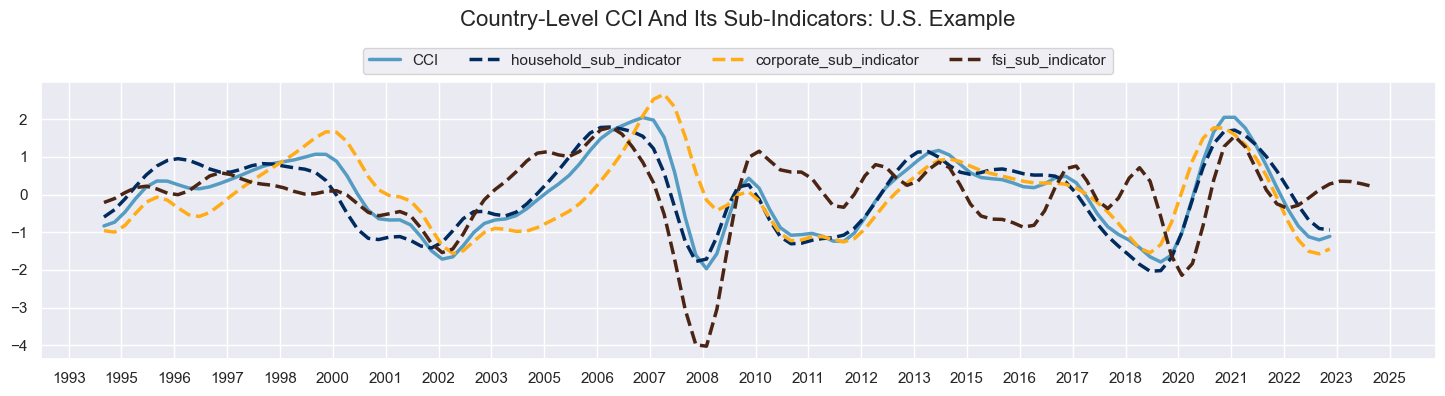

In [19]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(18, 3.6))

# Plotando as séries temporais:
plt.plot(cci, label='CCI', color='#559cc3', linewidth=2.5)
plt.plot(sub_indicators['household_sub_indicator'], label='household_sub_indicator', color='#002b5f', linestyle='--', linewidth=2.5)
plt.plot(sub_indicators['corporate_sub_indicator'], label='corporate_sub_indicator', color='#ffac17', linestyle='--', linewidth=2.5)
plt.plot(sub_indicators['fsi_sub_indicator'], label='fsi_sub_indicator', color='#4b2514', linestyle='--', linewidth=2.5)

# Ajuste o formato das datas no eixo x para ano/mês:
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Country-Level CCI And Its Sub-Indicators: U.S. Example', fontsize=16, pad=40)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.show()

In [ ]:
# Add data
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
            'August', 'September', 'October', 'November', 'December']
high_2000 = [32.5, 37.6, 49.9, 53.0, 69.1, 75.4, 76.5, 76.6, 70.7, 60.6, 45.1, 29.3]
low_2000 = [13.8, 22.3, 32.5, 37.2, 49.9, 56.1, 57.7, 58.3, 51.2, 42.8, 31.6, 15.9]
high_2007 = [36.5, 26.6, 43.6, 52.3, 71.5, 81.4, 80.5, 82.2, 76.0, 67.3, 46.1, 35.0]
low_2007 = [23.6, 14.0, 27.0, 36.8, 47.6, 57.7, 58.9, 61.2, 53.3, 48.5, 31.0, 23.6]
high_2014 = [28.8, 28.5, 37.0, 56.8, 69.7, 79.7, 78.5, 77.8, 74.1, 62.6, 45.3, 39.9]
low_2014 = [12.7, 14.3, 18.6, 35.5, 49.9, 58.0, 60.0, 58.6, 51.7, 45.2, 32.2, 29.1]

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=month, y=high_2014, name='High 2014',
                            line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=month, y=low_2014, name = 'Low 2014',
                            line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=month, y=high_2007, name='High 2007',
                            line=dict(color='firebrick', width=4,
                                dash='dash') # dash options include 'dash', 'dot', and 'dashdot'
))
fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
                            line = dict(color='royalblue', width=4, dash='dash')))
fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
                            line = dict(color='firebrick', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=month, y=low_2000, name='Low 2000',
                            line=dict(color='royalblue', width=4, dash='dot')))

# Edit the layout
fig.update_layout(title='Average High and Low Temperatures in New York',
                    xaxis_title='Month',
                    yaxis_title='Temperature (degrees F)')

fig.show()

Calculando o CCI Global ou Regional:

O CCI regional ou global é calculado como a média dos CCIs de países disponíveis, começando do período em que todos os dados estão disponíveis (por exemplo, Q1 1995). Se o CCI de um país não estiver disponível em um determinado período, a média dos CCIs restantes é usada. A série resultante é então padronizada para ter média zero e desvio padrão um.

A fórmula para calcular o CCI regional é:

\begin{equation}
\text{CCI}_{\text{regional}} = \frac{\text{CCI} - \mu_{\text{regional}}}{\sigma_{\text{regional}}}
\end{equation}

Onde:
* $\text{CCI}$ é a média dos CCIs disponíveis em cada período.
* $\mu_{\text{regional}}$ é a média da série regional.
* $\sigma_{\text{regional}}$ é o desvio padrão da série regional.

In [ ]:
def calculate_regional_cci(country_ccis, start_period='1995Q1'):
    """
    Calcula o CCI regional ou global como a média dos CCIs de países disponíveis, e rescale a série.

    Parameters:
    country_ccis (dict): Dicionário onde a chave é o nome do país e o valor é a série temporal do CCI do país.
    start_period (str): Período inicial para cálculo, formato 'YYYYQX'.

    Returns:
    pd.Series: Série padronizada representando o CCI regional ou global.
    """
    # Trunca as séries para começar do período especificado
    truncated_ccis = {name: cci.loc[start_period:] for name, cci in country_ccis.items()}
    
    # Cria um DataFrame com todas as séries truncadas
    df_ccis = pd.DataFrame(truncated_ccis)
    
    # Calcula a média dos CCIs disponíveis em cada período
    regional_cci = df_ccis.mean(axis=1)
    
    # Padroniza a série regional
    regional_cci = (regional_cci - regional_cci.mean()) / regional_cci.std()
    
    return regional_cci

# Exemplo de uso
# Supomos que você já tenha os CCIs calculados para diferentes países:
us_cci = pd.Series(...)   # CCI dos EUA
uk_cci = pd.Series(...)   # CCI do Reino Unido
de_cci = pd.Series(...)   # CCI da Alemanha
fr_cci = pd.Series(...)   # CCI da França

# Dicionário de CCIs dos países
country_ccis = {
    'US': us_cci,
    'UK': uk_cci,
    'DE': de_cci,
    'FR': fr_cci
}

# Calcula o CCI regional
regional_cci = calculate_regional_cci(country_ccis, start_period='1995Q1')
print(regional_cci.head())

### Testes e Resultados

Testes mostraram que os picos do CCI geralmente precedem períodos de estresse de crédito por 18 meses a 3 anos. A capacidade do CCI de antecipar estresse é verificada comparando seus picos com spreads de alta performance e ações de classificação da S&P.

### Interpretação

A interpretação do Indicador de Ciclo de Crédito (CCI) envolve entender como os diferentes componentes que constituem o índice refletem o ambiente de crédito e a saúde financeira de uma economia. Abaixo estão os principais pontos que devem ser considerados:

**Níveis do CCI:**
* **Níveis Positivos do CCI:** Quando o CCI é positivo, isso sugere que o ambiente de crédito está em um estado de expansão ou crescimento. Este cenário pode indicar que há um aumento no endividamento das famílias e corporações, bem como uma valorização dos preços dos ativos, como imóveis e ações.
* **Níveis Negativos do CCI:** Quando o CCI é negativo, isso indica que o ambiente de crédito está contraindo. Este cenário pode ser caracterizado por uma diminuição no endividamento e uma queda nos preços dos ativos, refletindo uma desaceleração econômica ou uma maior restrição no crédito.

**Componentes do CCI:**

**Crédito/PIB (Famílias e Corporativas):**

* Este componente mede a relação entre o crédito total fornecido às famílias e corporações não financeiras em relação ao PIB. Um aumento significativo neste componente pode indicar um risco crescente de endividamento excessivo.

**Preços de Ativos (Ações e Imóveis):**

* Este componente considera a valorização dos preços das ações e imóveis. Preços de ativos crescentes podem ser sinais de um mercado aquecido, mas também podem indicar a formação de bolhas especulativas.

**Indicador de Estresse de Financiamento (FSI):**

* O FSI mede as condições de financiamento no mercado. Leituras positivas do FSI indicam condições de financiamento mais frouxas, o que pode fomentar o crescimento do crédito, enquanto leituras negativas indicam condições mais restritivas.

**Ciclos Econômicos:**

**A interpretação do CCI deve ser contextualizada dentro dos ciclos econômicos:**

* **Fase de Expansão:** Durante uma fase de expansão econômica, o CCI tende a aumentar, refletindo um crescimento no crédito e valorização dos ativos.
* **Fase de Contração:** Durante uma fase de contração econômica, o CCI tende a diminuir, refletindo uma redução no crédito e depreciação dos ativos.

**Indicador Antecipado:**

O CCI é considerado um indicador antecipado, pois seus picos e vales geralmente precedem mudanças significativas nas condições econômicas:

* **Antecipação de Crises:** Picos no CCI podem preceder crises financeiras, indicando um período de endividamento excessivo e valorização insustentável dos ativos.
* **Recuperação Econômica:** Vales no CCI podem sinalizar o início de uma recuperação econômica, indicando uma estabilização das condições de crédito e valorização dos ativos.

### Conclusão

O CCI serve como indicador antecipado de estresse de crédito, sinalizando excessos ou desequilíbrios no setor não financeiro privado. Ao interpretar o CCI, é importante considerar o nível atual, a tendência e o momento de mudança. O CCI não é um critério de classificação da S&P, mas uma ferramenta para facilitar discussões sobre riscos de crédito.

### Limitações e Exploração Futura

`O CCI não captura todos os fatores de risco, como choques exógenos`, e sua interpretação precisa levar em conta o atraso na disponibilidade dos dados. Futuras explorações podem incluir sistemas de ponderação alternativos, sinalização de variáveis de crédito específicas de indústrias, e comparações mais profundas com indicadores relacionados.

### Referências

* Drehmann, M., Borio, C. E., & Tsatsaronis, K. (2012). Characterising the financial cycle: don't 
lose sight of the medium term!. BIS Working Paper No. 380

* Greenwood, R., Hanson, S. G., Shleifer, A., & Sørensen, J. A. (2020). Predictable financial crises. 
National Bureau of Economic Research (No. w27396)

* Christiano, L. J., & Fitzgerald, T. J. (2003). The band pass filter. International Economic Review, 
44(2), 435-465.

## Recriação do Indicador de Ciclo de Crédito (CCI) para o Brasil.

##### Leitura das Bases:

Função para obter dados do IPCA e o IBOVESPA Deflacionado:

In [40]:
def get_ipca():
    url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
    response = requests.get(url)
    data = response.json()
    df_ipca = pd.DataFrame(data)
    df_ipca['data'] = pd.to_datetime(df_ipca['data'], format='%d/%m/%Y')
    df_ipca.set_index('data', inplace=True)
    df_ipca['valor'] = df_ipca['valor'].astype(float)
    return df_ipca

def real_ibov():
    # Obter dados históricos do Ibovespa:
    ibovespa = yf.download('^BVSP', start='1994-01-01')

    # Obter dados do IPCA:
    ipca = get_ipca()

    # Converter os valores do IPCA para um índice cumulativo (base 100):
    ipca['ipca_index'] = ipca['valor'].cumsum()
    ipca['ipca_index'] = 100 + ipca['ipca_index']

    # Ajustar a frequência do IPCA para mensal para combinar com os dados do Ibovespa:
    ipca_monthly = ipca.resample('ME').last()

    # Alinhar os dados do Ibovespa com os do IPCA:
    ibovespa_monthly = ibovespa.resample('ME').last()

    # Combinar os dados do Ibovespa com os do IPCA:
    combined_data = pd.concat([ibovespa_monthly['Close'], ipca_monthly['ipca_index']], axis=1)

    # Renomear as colunas para facilitar a compreensão:
    combined_data.columns = ['Ibovespa', 'IPCA_Index']

    # Remover valores NaN (geralmente no início da série onde pode não haver correspondência exata):
    combined_data.dropna(inplace=True)

    # Calcular a série deflacionada do Ibovespa:
    combined_data['real_ibov'] = combined_data['Ibovespa'] / combined_data['IPCA_Index']
    combined_data['real_ibov'] = combined_data['real_ibov'] * combined_data['IPCA_Index'].iloc[0]

    return combined_data['real_ibov']

Leitura dos dados dos componentes do CCI Brazil:

In [54]:
def process_excel(file_path, date_column='date'):
    df = pd.read_excel(file_path)
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    return df

# Caminhos:
household_sector_br_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão BR\Dados\Total Credit to Households and NPISHs, Adjusted for Breaks, for Brazil.xls'
private_sector_br_path =  r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão BR\Dados\Total Credit to Private Non-Financial Sector, Adjusted for Breaks, for Brazil.xls'
real_residential_br_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão BR\Dados\Real Residential Property Prices for Brazil.xls'
fsi_br_path = r'C:\Users\jonas\OneDrive - MSFT\Desktop\Replicar CCI da S&P Rating\Versão USA\Dados\fsi.csv'

# Processando os CSVs:
household_sector_br = process_excel(household_sector_br_path)
private_sector_br = process_excel(private_sector_br_path)
real_residential_br = process_excel(real_residential_br_path)
real_bov = real_ibov()

# Caso especial para o FSI:
fsi_em = pd.read_csv(fsi_br_path).rename(columns={'Emerging markets': 'fsi_em'})
fsi_em.drop(columns=['OFR FSI', 'Credit', 'Equity valuation', 'Safe assets',
                'Funding', 'Volatility', 'Other advanced economies',
                'United States'], inplace=True)

fsi_em['Date'] = pd.to_datetime(fsi_em['Date'])
fsi_em.set_index('Date', inplace=True)

[*********************100%%**********************]  1 of 1 completed


##### Manipulação das Bases:

`IBOV Defl`:

In [55]:
real_bov_quarterly = real_bov.resample('QE').last()
real_bov_quarterly.index = real_bov_quarterly.index + pd.offsets.QuarterBegin(startingMonth=1)
real_bov_quarterly.head(3)

1994-04-01    1470.977819
1994-07-01    3356.838155
1994-10-01    5063.305179
Name: real_ibov, dtype: float64

`FSI EM`:

In [56]:
fsi_em_quarterly = fsi_em.resample('QE').last()
fsi_em_quarterly.index = fsi_em_quarterly.index + pd.offsets.QuarterBegin(startingMonth=1)
fsi_em_quarterly.head(3)

,fsi_em
Date,
2000-04-01,0.051
2000-07-01,0.056
2000-10-01,0.117


##### Tratamentos e Transformações de Dados: Statistical Filter

In [63]:
def get_cycles(series_dict, low=6, high=40):
    """
    Obtém os componentes de ciclo para uma lista de séries temporais.

    Parameters:
    series_dict (dict): Dicionário onde a chave é o nome da série e o valor é a série temporal (pandas Series).
    low (int): Período baixo do filtro para obter os ciclos.
    high (int): Período alto do filtro para obter os ciclos.

    Returns:
    pd.DataFrame: DataFrame contendo os componentes de ciclo de cada série.
    """

    cycles = {}
    for name, series in series_dict.items():
        cycle, trend = cffilter(series, low=low, high=high)
        cycles[name] = cycle
    return pd.DataFrame(cycles)

# Aqui já será incluida as transformações necessárias para cada série:
series_dict = {
    # Não há nenhuma Transformação:
    'household': household_sector_br['credit_households'],
    'private': private_sector_br['credit_private'],
    
    # Transformação 'Logaritmo Natural':
    'residential': np.log(real_residential_br),
    'equity': np.log(real_bov_quarterly),
    
    # Transformação 'Negativo do logaritmo natural':
    # Aqui foi preciso alterar a escala da série, pois ela usa números índices, e 
    # usar tanto o ln quanto o -ln ocorrera um erro devido a valores negativos.
    # A escala utilizada foi a seguinte: (x*1)+10.
    'fsi_em': -np.log((fsi_em_quarterly - fsi_em_quarterly.mean() / fsi_em_quarterly.std())*1+10)
}

cycles_br = get_cycles(series_dict)
print(cycles_br.tail(10))

            household   private  residential    equity    fsi_em
2022-07-01   0.432709  1.183101    -0.015296 -0.125585 -0.018497
2022-10-01   0.313941  0.498161    -0.023794 -0.134942 -0.018344
2023-01-01   0.104617 -0.337380    -0.029931 -0.125265 -0.013357
2023-04-01  -0.048338 -0.838094    -0.034669 -0.103544 -0.007340
2023-07-01  -0.060461 -0.851416    -0.038200 -0.074375 -0.002235
2023-10-01   0.039682 -0.596109    -0.040182 -0.043092  0.002045
2024-01-01        NaN       NaN    -0.040238 -0.017627  0.006167
2024-04-01        NaN       NaN          NaN -0.005310  0.009953
2024-07-01        NaN       NaN          NaN -0.007151  0.012246
2024-10-01        NaN       NaN          NaN       NaN  0.011999


##### Tratamentos e Transformações de Dados: Further Specifics

In [72]:
zscore_br = cycles_br.apply(lambda x:
                    (x-x.mean())/x.std(), axis=0)

zscore_br.tail()

,household,private,residential,equity,fsi_em
2023-10-01,0.081406,-0.215096,-1.328529,-0.304042,0.085162
2024-01-01,NaN,NaN,-1.330334,-0.138518,0.208215
2024-04-01,NaN,NaN,NaN,-0.058450,0.321205
2024-07-01,NaN,NaN,NaN,-0.070422,0.389680
2024-10-01,NaN,NaN,NaN,NaN,0.382284


##### Weighted Sum And Final Standardization

In [78]:
def weighted_sum_and_standardize(cycles_dict, weights, start_period='1995Q1'):
    """
    Calcula a soma ponderada das séries de ciclos e padroniza o resultado final,
    começando do período em que todos os dados estão disponíveis.

    Parameters:
    cycles_dict (dict): Dicionário onde a chave é o nome da série e o valor é a série temporal filtrada (ciclo).
    weights (dict): Dicionário onde a chave é o nome da série e o valor é o peso atribuído a ela.
    start_period (str): Período inicial para cálculo, formato 'YYYYQX'.

    Returns:
    pd.Series: Série padronizada representando o Credit Cycle Indicator (CCI).
    """
    # Truncar a série para começar no período especificado:
    truncated_cycles = {name: cycles.loc[start_period:] for name, cycles in cycles_dict.items()}

    # Calcula a soma ponderada das séries de ciclos:
    weighted_sum = sum(weights[name] * cycles for name, cycles in truncated_cycles.items())

    # Padroniza a soma ponderada:
    cci = (weighted_sum - weighted_sum.mean()) / weighted_sum.std()
    return cci

def calculate_sub_indicators(cycles_dict, start_period='1995Q1'):
    """
    Calcula os sub-indicadores para domicílios e empresas.

    Parameters:
    cycles_dict (dict): Dicionário onde a chave é o nome da série e o valor é a série temporal filtrada (ciclo).
    start_period (str): Período inicial para cálculo, formato 'YYYYQX'.

    Returns:
    dict: Dicionário contendo os sub-indicadores padronizados.
    """
    # Trunca as séries para começar do período especificado
    truncated_cycles = {name: cycles.loc[start_period:] for name, cycles in cycles_dict.items()}

    # Calcula o sub-indicador para domicílios (média dos componentes relevantes)
    household_sub_indicator = (truncated_cycles['household'] + truncated_cycles['residential']) / 2

    # Calcula o sub-indicador para empresas (média dos componentes relevantes)
    corporate_sub_indicator = (truncated_cycles['private'] + truncated_cycles['equity']) / 2

    # FSI já está truncado e não precisa de cálculos adicionais
    fsi_sub_indicator = truncated_cycles['fsi_em']

    # Padroniza os sub-indicadores
    household_sub_indicator = (household_sub_indicator - household_sub_indicator.mean()) / household_sub_indicator.std()
    corporate_sub_indicator = (corporate_sub_indicator - corporate_sub_indicator.mean()) / corporate_sub_indicator.std()
    fsi_sub_indicator = (fsi_sub_indicator - fsi_sub_indicator.mean()) / fsi_sub_indicator.std()

    return {
        'household_br_sub_indicator': household_sub_indicator,
        'corporate_br_sub_indicator': corporate_sub_indicator,
        'fsi_em_sub_indicator': fsi_sub_indicator
    }

# Dicionário de ciclos:
cycles_br_dict = {
    'household': zscore_br['household'],
    'private': zscore_br['private'],
    'residential': zscore_br['residential'],
    'equity': zscore_br['equity'],
    'fsi_em': zscore_br['fsi_em']
}

# Dicionário de pesos:
weights_br = {
    'household': 0.20,
    'private': 0.20,
    'residential': 0.20,
    'equity': 0.20,
    'fsi_em': 0.20
}

In [92]:
cci_br = weighted_sum_and_standardize(cycles_br_dict, weights_br, start_period='2001Q2')

print(Fore.CYAN + Style.BRIGHT + 'Credit Cycle Indicator (CCI) - Brazil:' + Style.RESET_ALL)
print(cci_br.head(10))

Credit Cycle Indicator (CCI) - Brazil:
2001-01-01    1.747025
2001-04-01    0.869693
2001-07-01    0.118575
2001-10-01   -0.207549
2002-01-01   -0.188963
2002-04-01   -0.193473
2002-07-01   -0.548942
2002-10-01   -1.253906
2003-01-01   -1.964294
2003-04-01   -2.257829
Freq: QS-OCT, dtype: float64


In [252]:
sub_indicators_br = pd.DataFrame(calculate_sub_indicators(cycles_br_dict, start_period='2001Q2'))

print('Household BR Sub-Indicator:')
print(sub_indicators_br['household_br_sub_indicator'].head())
print('')
print('Corporate BR Sub-Indicator:')
print(sub_indicators_br['corporate_br_sub_indicator'].head())
print('')
print('FSI EM Sub-Indicator:')
print(sub_indicators_br['fsi_em_sub_indicator'].head())

Household BR Sub-Indicator:
2001-01-01    2.843060
2001-04-01    1.409330
2001-07-01    0.242091
2001-10-01   -0.208298
2002-01-01   -0.095325
Freq: QS-OCT, Name: household_br_sub_indicator, dtype: float64

Corporate BR Sub-Indicator:
2001-01-01    0.963609
2001-04-01    0.698476
2001-07-01    0.314144
2001-10-01    0.079146
2002-01-01    0.097288
Freq: QS-OCT, Name: corporate_br_sub_indicator, dtype: float64

FSI EM Sub-Indicator:
2001-01-01   -0.337254
2001-04-01   -0.365428
2001-07-01   -0.322801
2001-10-01   -0.313517
2002-01-01   -0.428097
Freq: QS-OCT, Name: fsi_em_sub_indicator, dtype: float64


Gráfico de comparação dos indicadores:

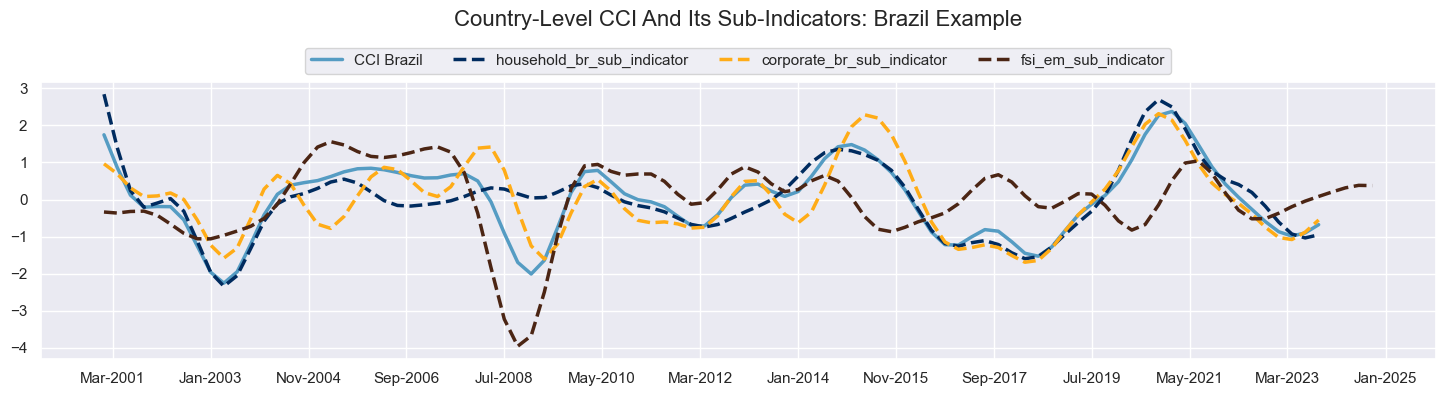

In [88]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(18, 3.6))

# Plotando as séries temporais:
plt.plot(cci_br, label='CCI Brazil', color='#559cc3', linewidth=2.5)
plt.plot(sub_indicators_br['household_br_sub_indicator'], label='household_br_sub_indicator', color='#002b5f', linestyle='--', linewidth=2.5)
plt.plot(sub_indicators_br['corporate_br_sub_indicator'], label='corporate_br_sub_indicator', color='#ffac17', linestyle='--', linewidth=2.5)
plt.plot(sub_indicators_br['fsi_em_sub_indicator'], label='fsi_em_sub_indicator', color='#4b2514', linestyle='--', linewidth=2.5)

# Ajuste o formato das datas no eixo x para ano/mês:
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=22))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.title('Country-Level CCI And Its Sub-Indicators: Brazil Example', fontsize=16, pad=40)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.show()

In [267]:
def to_quarter(date):
    quarter = (date.month - 1) // 3 + 1
    return f'Q{quarter}-{date.year}'

fig = go.Figure()

# Adicionando as séries temporais:
fig.add_trace(go.Scatter(x=cci_br.index, y=cci_br, name='CCI Brazil',
                            line=dict(color='#559cc3', width=4.5)))
fig.add_trace(go.Scatter(x=cci_br.index, y=sub_indicators_br['household_br_sub_indicator'], name='Household Br sub-indicator',
                            line=dict(color='#002b5f', width=4.5, dash='dash')))
fig.add_trace(go.Scatter(x=cci_br.index, y=sub_indicators_br['corporate_br_sub_indicator'], name='Corporate Br sub-indicator',
                            line=dict(color='#ffac17', width=4.5, dash='dash')))
fig.add_trace(go.Scatter(x=cci_br.index, y=sub_indicators_br['fsi_em_sub_indicator'], name='FSI EM sub-indicator',
                            line=dict(color='#4b2514', width=4.5, dash='dash')))

# Ajuste do layout:
fig.update_layout(
    title={
        'text': 'Country-Level CCI And Its Sub-Indicators: Brazil Example',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 25, 'color': 'black', 'family': 'Aptos'}
    },
    annotations=[
        dict(
            x=0.5,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Credit Cycle Stage (CCS)',
            showarrow=False,
            font=dict(size=22, color='black', family='Aptos')
        )
    ],
    xaxis_title={
        'text': 'Credit Cycle Indicator (CCI)',
        'font': {'size': 22, 'color': 'black', 'family': 'Aptos'}
    },
    yaxis_title={
        'text': 'Std dev',
        'font': {'size': 22, 'color':'black', 'family': 'Aptos'}},
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.06,
        xanchor="center",
        x=0.5,
        font=dict(size=15, color='black', family='Aptos')
    ),
    xaxis=dict(
        tickvals=cci_br.index[::2],
        ticktext=[to_quarter(date) for date in cci_br.index[::2]],
        tickfont=dict(size=19, color='black', family='Aptos') 
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=0.5
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200,
    height=480
)
fig.show()